# Loading DICOM Data

In [1]:
import sys
sys.path.append('/home/gpuvmadm/PyTomography/src')
import os
from pytomography.projections import ForwardProjectionNet, BackProjectionNet
from pytomography.metadata import ObjectMeta, ImageMeta, PSFMeta
from pytomography.mappings import SPECTAttenuationNet, SPECTPSFNet
from pytomography.algorithms import OSEMOSL
from pytomography.io import dicom_projections_to_data, dicom_CT_to_data
import numpy as np
import matplotlib.pyplot as plt
import torch
import pydicom
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In DICOM format, it is typically the case that SPECT tomography is contained in a `.dcm` file, and CT data is contained in a sequence of `.dcm` files: each file corresponding to a different axial slice. To open this data for reconstruction in pytomography, we need a single SPECT filepath and multiple CT filepaths.

In [2]:
path_CT = '/home/gpuvmadm/PyTomography/test_files/ohif_CT'
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]
file_NM = '/home/gpuvmadm/PyTomography/test_files/ohif_NM.dcm'

We can get the object/image metadata and corresponding projections using the `dicom_projections_to_data` function.

In [3]:
object_meta, image_meta, projections = dicom_projections_to_data(file_NM)
projections.shape

torch.Size([2, 64, 128, 128])

Note the size of the projections: we now have 2 energy windows corresponding to this SPECT scan, so the batch dimension now stores each scan.

We can load the CT data using the `dicom_CT_to_data`. It takes in both the CT file path and SPECT file path, and returns 3D tensor of dimensions `[Lx, Ly, Lz]` containing the CT array. It uses the tomography data from `file_NM` to align the CT data with the SPECT projections using `affine` transformations and resampling:

In [4]:
CT = dicom_CT_to_data(files_CT, file_NM).unsqueeze(dim=0)

Note that up to this point, we've used pytomography functions to load the data. Sometimes, however, DICOM files may not follow the strict rules for storing SPECT/CT data. In this case, as long as you can get (i) `object_meta`, (ii) `image_meta`, (iii) `projections` and (iv) `CT` from the corresponding DICOM files, you are set. The image metadata requires the angles (and if you want to use PSF correction, also the radii) of each projection. This can typically be found in the `ds.RotationInformationSequence` and `ds.DetectorInformationSequence` attributes of a loaded dicom file using `pydicom.read_file(filename)`. For more information, see `pytomography.io.dicom`: you can use similar functionality to load your own data. 

It's also important that the CT data is aligned with the projections. This can be accomplished by using affine transformations: for more information, see functionality in `pytomography.io.dicom`. 

As usual, it is always good practice to ensure the CT and projections are aligned

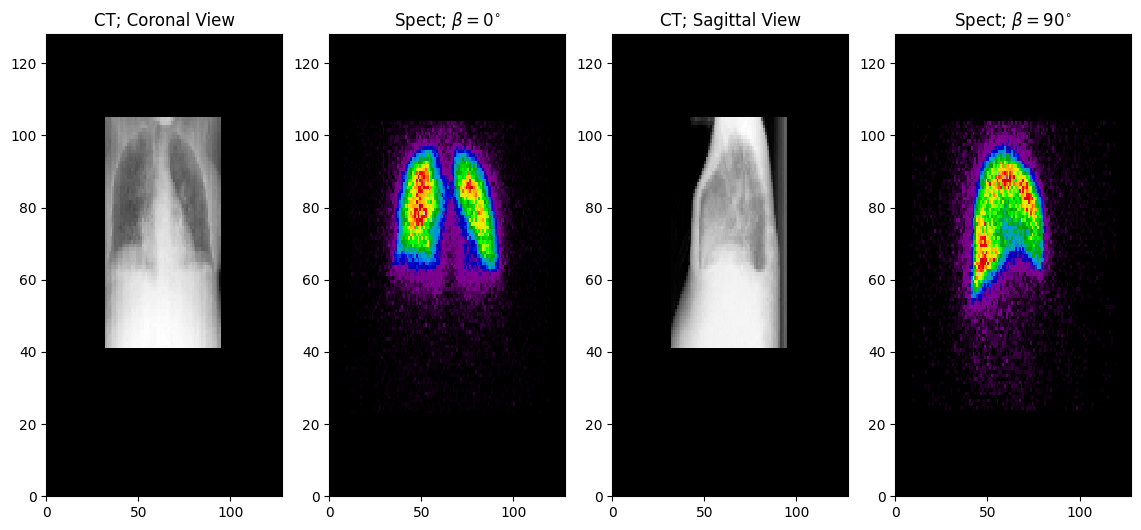

In [5]:
plt.subplots(1, 4, figsize=(14,6))
plt.subplot(141)
plt.pcolormesh(CT[0].sum(axis=1).T, cmap='Greys_r')
plt.title('CT; Coronal View')
plt.subplot(142)
plt.pcolormesh(projections[0][0].T, cmap='nipy_spectral')
plt.title(r'Spect; $\beta=0^{\circ}$')
plt.subplot(143)
plt.pcolormesh(CT[0].sum(axis=0).T, cmap='Greys_r')
plt.title('CT; Sagittal View')
plt.subplot(144)
plt.pcolormesh(projections[0][16].T, cmap='nipy_spectral')
plt.title(r'Spect; $\beta=90^{\circ}$')
plt.show()

* Note the CT scan is cut-off; the detector did not cover the full patient during the scan

We can use this information to create an `OSEMNet` object, which will be used for ordered subset expectation maximum reconstruction.

$$f_i^{(n+1)} = \frac{f_i^{(n)}}{\sum_j c_{ij} + \beta \frac{\partial V}{\partial f_r}|_{f_i=f_i^{(n)}}} \sum_j c_{ij}\frac{g_j}{\sum_i c_{ij}f_i^{(n)}} $$

First we need to give all required information for the forward projection operator $\sum_i c_{ij} a_i$ and the back projection operator $\sum_j c_{ij} b_j$ work.

* This amounts to defining the type of modeling we want to use. First, let's get the network that models attenuation corrrection.

In [6]:
ct_net = SPECTAttenuationNet(CT, device=device)

For quantitative reconstruction, we'll want to also model PSF blurring. This requires knowing the `collimator_slope` and `collimator_intercept` parameters of the scanner. The assumption is that the PSF function is Gaussian with width $\sigma$ dependent on the distance from the detector: 
$\sigma =$ `collimator_slope` $\cdot d + $ `collimator_intercept`. This information depends on the detector used: in particular, the collimator dimensions. These may be found in a data sheet for your particular scanner. It can also be determined by scanning a point source at various detector distances $d$, fitting each projection to a Gaussian profile and determining the width $\sigma$, and then fitting $d$ vs. $\sigma$ to a linear curve: 

In [7]:
psf_meta = PSFMeta(collimator_slope = 0.02, collimator_intercept = 0.005)
psf_net = SPECTPSFNet(psf_meta, device)

Then we make sure to include these correction networks in the forward/back projection networks. It's important that CT correction occurs first.

In [8]:
fp_net = ForwardProjectionNet(obj2obj_nets=[ct_net, psf_net],
                              im2im_nets=[],
                              object_meta=object_meta,
                              image_meta=image_meta,
                              device=device)
bp_net = BackProjectionNet(obj2obj_nets=[ct_net, psf_net],
                           im2im_nets=[],
                           object_meta=object_meta,
                           image_meta=image_meta,
                           device=device)

Then we create the OSEM net:

In [9]:
osem_net = OSEMOSL(image = projections,
                   forward_projection_net=fp_net,
                   back_projection_net=bp_net)

Finally, we reconstruct:

In [10]:
reconstructed_object = osem_net(n_iters=2, n_subsets=8)
reconstructed_object.shape

torch.Size([2, 128, 128, 128])

We have two objects (one for each energy window). We can look at each energy window seperately:

In [11]:
main_energy_window = reconstructed_object[0].cpu().numpy()
lower_energy_window = reconstructed_object[1].cpu().numpy()

Let's look at an axial slice:

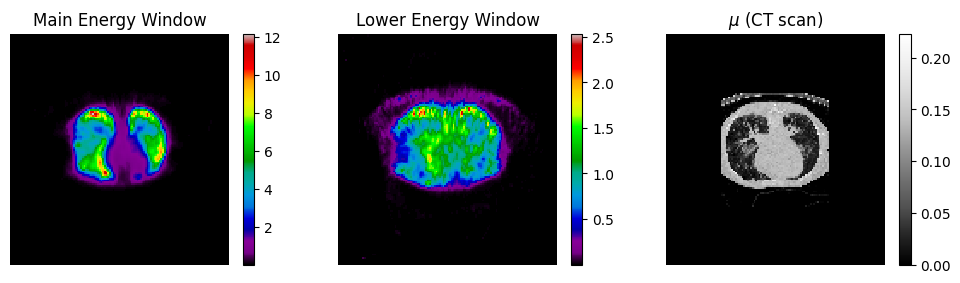

In [12]:
plt.subplots(1,3,figsize=(12,3))
plt.subplot(131)
plt.pcolormesh(main_energy_window[:,:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('Main Energy Window')
plt.subplot(132)
plt.pcolormesh(lower_energy_window[:,:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('Lower Energy Window')
plt.subplot(133)
plt.pcolormesh(CT[0,:,:,70].T, cmap='Greys_r')
plt.colorbar()
plt.axis('off')
plt.title('$\mu$ (CT scan)')
plt.show()